# Credit Card Fraud Detection Project

In [69]:
%matplotlib inline
import scipy.stats as stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.dummy import DummyClassifier
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, f1_score, fbeta_score, accuracy_score, balanced_accuracy_score
from sklearn.utils import class_weight
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline

plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')


In [70]:
df = pd.read_csv("creditcard.csv")

## 1. Exploratory Data Analysis

In [71]:
df.sample(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
8514,11427.0,-0.412239,0.698986,2.185035,0.472523,-0.443065,-0.627872,0.038587,-0.070673,0.931770,...,-0.220892,-0.462696,-0.109524,0.372409,-0.242245,1.153809,-0.023788,0.067143,8.14,0
95578,65377.0,-0.571130,1.089999,1.415888,0.482882,0.125651,-0.135976,0.428806,0.073574,-0.803596,...,-0.050477,-0.223934,0.098747,0.188307,-0.753684,0.141148,-0.129746,0.140735,1.79,0
30148,35795.0,-1.793073,0.890014,0.585687,0.992464,-0.157620,-0.773120,0.859642,-0.242650,-0.224064,...,0.061622,0.513733,-0.274721,0.441482,-0.241535,-0.402184,-0.440789,0.019207,93.72,0
281360,170124.0,0.273256,-0.195171,1.241294,-0.299054,-0.106237,0.445270,-0.281907,-0.152379,1.206818,...,0.429099,1.668978,0.327111,0.820347,-2.682702,0.263174,-0.200512,-0.013458,17.97,0
88554,62189.0,-0.420930,0.762651,0.960768,0.317460,-0.650647,-0.566987,0.200835,0.372217,0.014667,...,0.069160,0.243666,0.024533,0.434262,-0.194786,0.437110,-0.105777,-0.029428,39.09,0


In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [73]:
df.isnull().sum().sum()

0

In [74]:
df.loc[:, ["Time","Amount"]].describe().T

,count,mean,std,min,25%,50%,75%,max
Time,284807.0,94813.859575,47488.145955,0.0,54201.5,84692.0,139320.500,172792.00
Amount,284807.0,88.349619,250.120109,0.0,5.6,22.0,77.165,25691.16


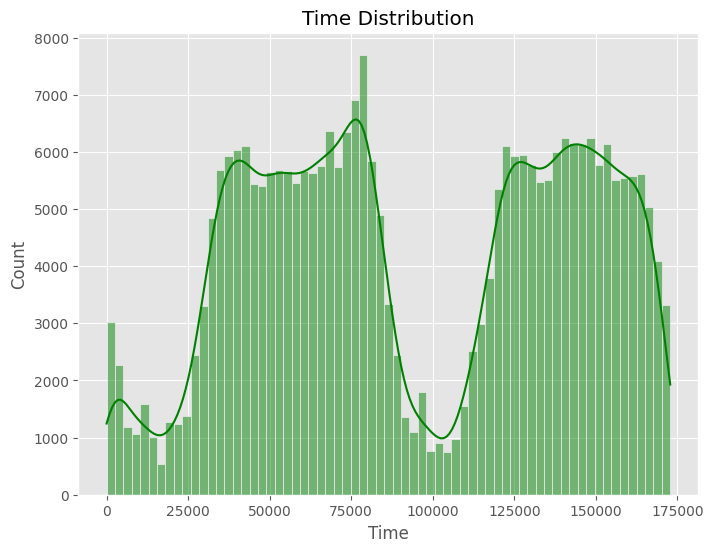

In [75]:
plt.figure(figsize=(8,6))
plt.title("Time Distribution")
sns.histplot(df["Time"], kde=True, color = "green")
plt.savefig('time_distribution.png');

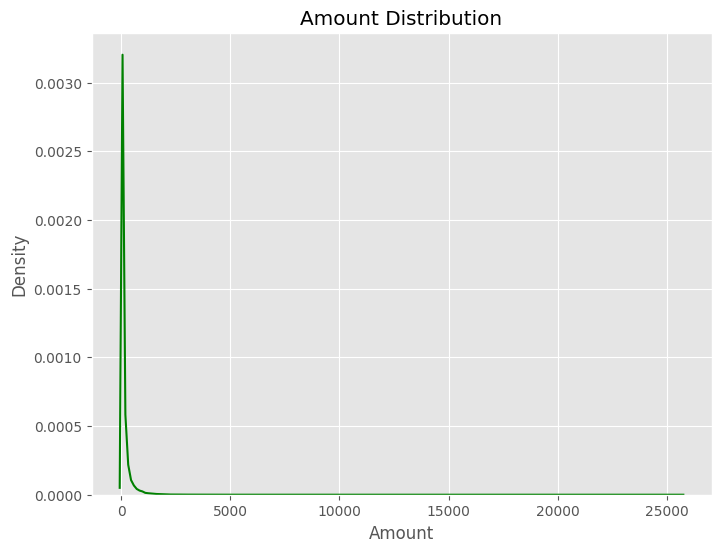

In [76]:
plt.figure(figsize=(8,6))
plt.title("Amount Distribution")
sns.kdeplot(df["Amount"], color = "green")
plt.savefig('amount_distribution.png');

In [77]:
fraud = df["Class"].value_counts()[1]
non_fraud = df["Class"].value_counts()[0]
print("Fraud:",fraud)
print("Non-Fraud:",non_fraud)

Fraud: 492
Non-Fraud: 284315


This dataa source is imbalance. This is fix with some techniques such as resampling methods. Oversampling, udersampling, smote methods under this topic. 

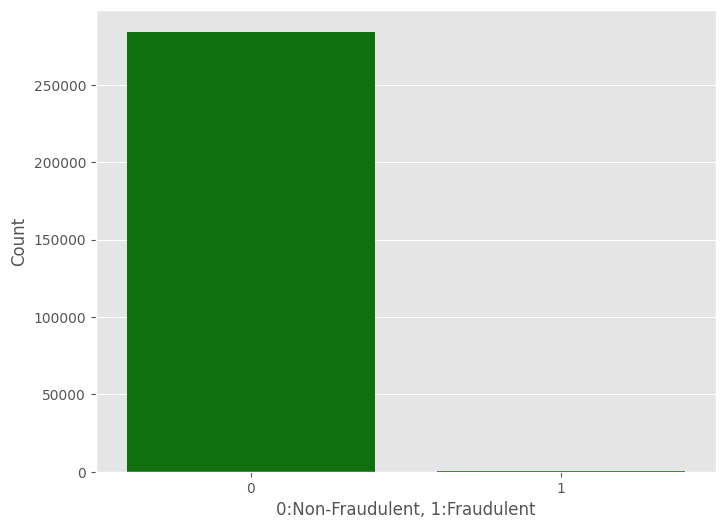

In [78]:
plt.figure(figsize=(8,6))
sns.barplot(x=df["Class"].value_counts().index, y=df["Class"].value_counts(), color ="green")
plt.ylabel('Count')
plt.xlabel('0:Non-Fraudulent, 1:Fraudulent')

# Save the plot as PNG file
plt.savefig('fraud_vs_nonfraud_transactions.png');

## 2. Data Processing

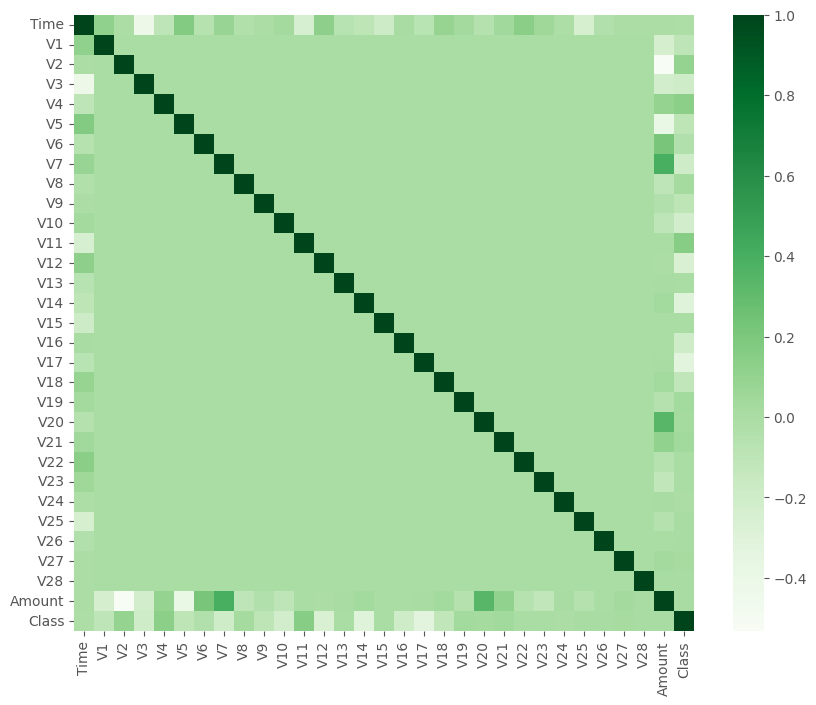

In [79]:
plt.figure(figsize=(10,8))
sns.heatmap(data = df.corr(), cmap="Greens", annot=False)

plt.savefig('corr_heatmap.png');

Time and V3 
Amount and V2
Amount and V4

## 3. Modeling

The dataset was divided into 60% for training, 20% for validation, and 20% for testing. To balance the imbalanced dataset, Random Undersampling was used to match the number of fraudulent transactions. Some classification models were used. 

In [80]:
data = df.drop(columns=["Class"])

target = df["Class"]

### Train - Test - Validation Splitting

In [81]:
X_trainval, X_test, y_trainval, y_test = train_test_split(data, target, test_size=0.2, random_state=42, stratify=df["Class"])

X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.25, random_state=42, stratify=y_trainval)

### Scaling

In [82]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [83]:
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
X_val_std = scaler.transform(X_val)

In [84]:
rus = RandomUnderSampler(random_state=42)

In [85]:
X_train_under, y_train_under = rus.fit_resample(X_train_std, y_train)

X_val_under, y_val_under = rus.fit_resample(X_val_std, y_val)

### Metrics Func

In [86]:
def get_metrics(y_true,y_pred):
    f1_scores_per_class = f1_score(y_true,y_pred,average=None)

    dict_metrics = {
        "Accuracy" : accuracy_score(y_true,y_pred),
        "Balanced Accuracy" : balanced_accuracy_score(y_true, y_pred),
        "Macro Recall" : recall_score(y_true, y_pred, average="macro"),
        "Macro Precision" : precision_score(y_true, y_pred, average="macro"),
        "Macro F1" : f1_score(y_true, y_pred, average="macro"),
        "F1 Scores per Class" : f1_scores_per_class
    }
    return dict_metrics

### Random Forest Classifier

In [114]:
parameter_grid = {
    "max_depth" : [5,10,15],
    "max_features" : ["sqrt"],
    "min_samples_leaf" : [10,20],
    "min_samples_split": [2, 5],
    "n_estimators": [500, 700]
}
rf_classifier = RandomForestClassifier()
rf_grid = GridSearchCV(rf_classifier, parameter_grid,cv=5, scoring='roc_auc', verbose=10, n_jobs=-1)
rf_grid.fit(X_train_under, y_train_under)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15], 'max_features': ['sqrt'],
                         'min_samples_leaf': [10, 20],
                         'min_samples_split': [2, 5],
                         'n_estimators': [500, 700]},
             scoring='roc_auc', verbose=10)

In [115]:
y_pred = rf_grid.predict(X_val_under)

metrics = get_metrics(y_val_under,y_pred)
metrics

{'Accuracy': 0.9242424242424242,
 'Balanced Accuracy': 0.9242424242424243,
 'Macro Recall': 0.9242424242424243,
 'Macro Precision': 0.9316860465116279,
 'Macro F1': 0.923914435762777,
 'F1 Scores per Class': array([0.92890995, 0.91891892])}

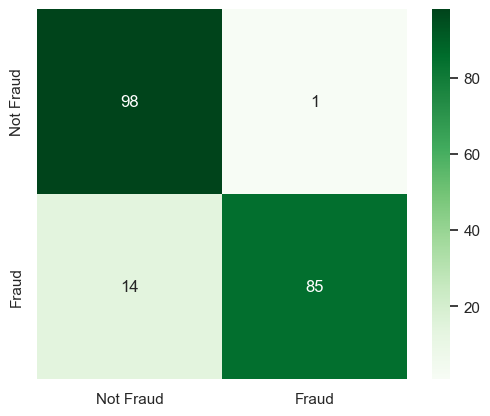

In [116]:
conf = confusion_matrix(y_val_under, y_pred)

plt.figure(dpi=100)
sns.heatmap(conf, cmap=plt.cm.Greens, annot=True, square=True, fmt='d',
        xticklabels=['Not Fraud', 'Fraud'],
        yticklabels=['Not Fraud', 'Fraud']);

### Logistic Regression

In [111]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2', "elasticnet"],  
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']  
}
log_reg = LogisticRegression()
log_reg_grid = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
log_reg_grid.fit(X_train_under, y_train_under)

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             scoring='accuracy')

In [112]:
y_pred = log_reg_grid.predict(X_val_under)

metrics = get_metrics(y_val_under,y_pred)
metrics

{'Accuracy': 0.9090909090909091,
 'Balanced Accuracy': 0.9090909090909092,
 'Macro Recall': 0.9090909090909092,
 'Macro Precision': 0.9117798089760707,
 'Macro F1': 0.908942258559019,
 'F1 Scores per Class': array([0.91262136, 0.90526316])}

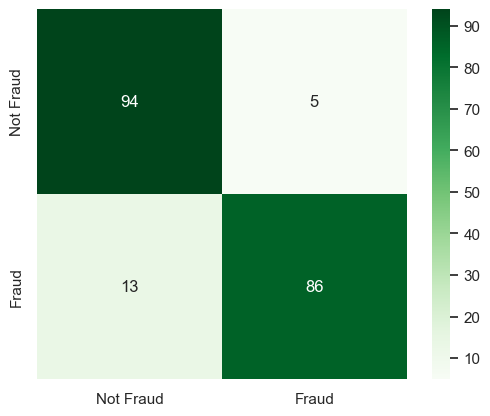

In [113]:
conf = confusion_matrix(y_val_under, y_pred)

plt.figure(dpi=100)
sns.heatmap(conf, cmap=plt.cm.Greens, annot=True, square=True, fmt='d',
        xticklabels=['Not Fraud', 'Fraud'],
        yticklabels=['Not Fraud', 'Fraud']);

### Gradient Boosting Classifier 

In [108]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2], 
    'max_depth': [3, 5, 7], 
    'min_samples_split': [2, 5, 10]  
}

gb_class = GradientBoostingClassifier(random_state=42)
gb_class_grid = GridSearchCV(gb_class, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
gb_class_grid.fit(X_train_under, y_train_under)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [109]:
y_pred = gb_class_grid.predict(X_val_under)

metrics = get_metrics(y_val_under,y_pred)
metrics

{'Accuracy': 0.9090909090909091,
 'Balanced Accuracy': 0.9090909090909092,
 'Macro Recall': 0.9090909090909092,
 'Macro Precision': 0.9117798089760707,
 'Macro F1': 0.908942258559019,
 'F1 Scores per Class': array([0.91262136, 0.90526316])}

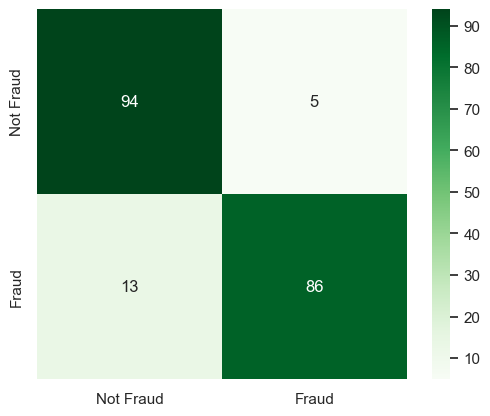

In [110]:
conf = confusion_matrix(y_val_under, y_pred)

plt.figure(dpi=100)
sns.heatmap(conf, cmap=plt.cm.Greens, annot=True, square=True, fmt='d',
        xticklabels=['Not Fraud', 'Fraud'],
        yticklabels=['Not Fraud', 'Fraud']);

### Naive Bayes

In [105]:
nb = GaussianNB()
nb.fit(X_train_under, y_train_under)

GaussianNB()

In [106]:
y_pred = nb.predict(X_val_under)

metrics = get_metrics(y_val_under,y_pred)
metrics

{'Accuracy': 0.8585858585858586,
 'Balanced Accuracy': 0.8585858585858586,
 'Macro Recall': 0.8585858585858586,
 'Macro Precision': 0.8609427955222347,
 'Macro F1': 0.8583546244251405,
 'F1 Scores per Class': array([0.86407767, 0.85263158])}

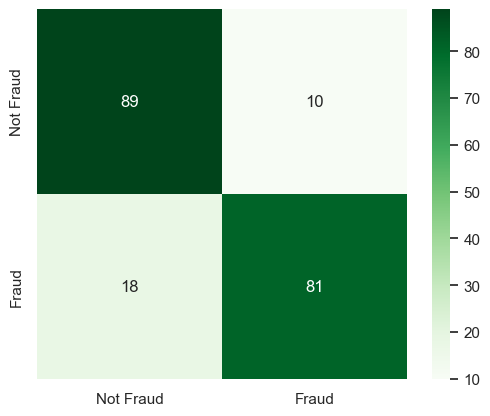

In [107]:
conf = confusion_matrix(y_val_under, y_pred)

plt.figure(dpi=100)
sns.heatmap(conf, cmap=plt.cm.Greens, annot=True, square=True, fmt='d',
        xticklabels=['Not Fraud', 'Fraud'],
        yticklabels=['Not Fraud', 'Fraud']);

### Dummy Classifier

In [98]:
dc = DummyClassifier()
dc.fit(X_train_under, y_train_under)

DummyClassifier()

In [99]:
y_pred = dc.predict(X_val_under)

metrics = get_metrics(y_val_under,y_pred)
metrics

{'Accuracy': 0.5,
 'Balanced Accuracy': 0.5,
 'Macro Recall': 0.5,
 'Macro Precision': 0.25,
 'Macro F1': 0.3333333333333333,
 'F1 Scores per Class': array([0.66666667, 0.        ])}

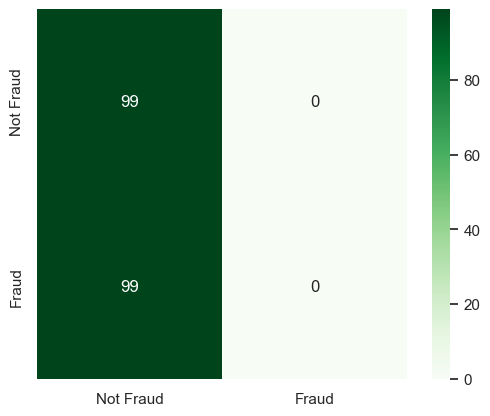

In [104]:
conf = confusion_matrix(y_val_under, y_pred)

plt.figure(dpi=100)
sns.heatmap(conf, cmap=plt.cm.Greens, annot=True, square=True, fmt='d',
        xticklabels=['Not Fraud', 'Fraud'],
        yticklabels=['Not Fraud', 'Fraud']);